<a id="table"></a>
<h1 style="padding: 15px; background-color: #010D36; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 200%; color: #F2F2F0; letter-spacing: 2px; text-align: center; border-radius: 8px;">Table of Contents</h1>

[1. Introduction](#1)

[2. Exploratory Data Analysis](#2)

[3. Preprocessing data](#3)

[4. Building Models](#4)

[5. References](#5)

[6. Member evaluation](#6)

<a id="1"></a>
<h1 style="background-color:white;font-family: 'JetBrains Mono';font-size:350%; color: #0d0d0d; text-align: left;border-radius: 15px 50px;">1. Introduction</h1>

<p style="
    font-size: 30px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    border-bottom: 3px solid #010D36;
">
    <b>General Remarks</b> 📔
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    margin-left: 20px;
    margin-right: 20px;
    margin-bottom: 20px;
">
    <b>In the original description, we read that:</b></br></br>
    <i>The competition data comprises over fifty anonymized health characteristics linked to three age-related conditions. Your goal is to predict whether a subject has or has not been diagnosed with one of these conditions - a binary classification problem.</br></br>
    Note that this is a Code Competition, in which the actual test set is hidden. In this version, we give some sample data in the correct format to help you author your solutions. When your submission is scored, this example test data will be replaced with the full test set. There are about $400$ rows in the full test set.</i>
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    margin-left: 20px;
    margin-right: 20px;
    margin-bottom: 20px;
">
    <b>Moreover, we know that:</b>
</p>

<ul style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li><b>train.csv</b> - <i>The training set.</i></li>
    <ul style="
        font-size: 20px;
        font-family: 'JetBrains Mono';
        color: #0d0d0d;
        margin-right: 8px;
    ">
        <li><code>Id</code> - <i>Unique identifier for each observation.</i></li>
        <li><code>AB-GL</code> - <i>Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.</i></li>
        <li><code>Class</code> - <i>A binary target: $1$ indicates the subject has been diagnosed with one of the three conditions, $0$ indicates they have not.</i></li>
    </ul>
    <li><b>test.csv</b> - <i>The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.</i></li>
    <li><b>greeks.csv</b> - <i>Supplemental metadata, only available for the training set.</i></li>
    <ul style="
        font-size: 20px;
        font-family: 'JetBrains Mono';
        color:#0d0d0d;
        margin-right: 8px;
    ">
        <li><code>Alpha</code> - <i>Identifies the type of age-related condition, if present.</i></li>
        <ul style="
            font-size: 20px;
            font-family: 'JetBrains Mono';
            color: #0d0d0d;
            margin-right: 8px;
        ">
            <li><code>A</code> - <i>No age-related condition. Corresponds to class $0$.</i></li>
            <li><code>B</code>, <code>D</code>, <code>G</code> - <i>The three age-related conditions. Correspond to class $1$.</i></li>
        </ul>
        <li><code>Beta</code>, <code>Gamma</code>, <code>Delta</code> - <i>Three experimental characteristics.</i></li>
        <li><code>Epsilon</code> - <i>The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.</i></li>
    </ul>
</ul>

<p style="
    font-size: 30px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    border-bottom: 3px solid #010D36;
">
    <b>Import libraries</b> 📔
</p>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import os, random
from IPython.display import display, HTML
import plotly.graph_objects as go
from datetime import datetime

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer 

from matplotlib.colors import Colormap
from itertools import product
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPClassifier
# from sklearn.impute import SimpleImputer
from catboost import Pool, CatBoostClassifier
import xgboost
from tabpfn import TabPFNClassifier

In [2]:
# Colors
DF_CMAP: Colormap = sns.light_palette("#8C92AC", as_cmap=True)  # type: ignore
FONT_COLOR = "#010D36"
BACKGROUND_COLOR = "#F6F5F5"

cell_hover = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": "background-color: #F6F5F5",
}
text_highlight = {
    "selector": "td",
    "props": "color: #FF2079; font-weight: bold",
}
index_names = {
    "selector": ".index_name",
    "props": "font-style: italic; background-color: #010D36; color: #F2F2F0;",
}
headers = {
    "selector": "th:not(.index_name)",
    "props": "font-style: italic; background-color: #010D36; color: #F2F2F0;",
}
DF_STYLE = (cell_hover, index_names, headers, text_highlight)

MY_RC = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": 10,
    "axes.labelpad": 15,
    "axes.labelweight": "bold",
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.titlepad": 15,
    "axes.facecolor": BACKGROUND_COLOR,
    "xtick.labelsize": 10,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": 10,
    "ytick.color": FONT_COLOR,
    "figure.titlesize": 14,
    "figure.titleweight": "bold",
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "font.size": 10,
    "font.family": "Serif",
    "text.color": FONT_COLOR,
}
sns.set_theme(rc=MY_RC)


<p style="
    font-size: 30px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    border-bottom: 3px solid #010D36;
">
    <b>Read data files</b> 📔
</p>


In [3]:
train = pd.read_csv('train.csv')
names = train.columns.tolist()
features = [x.replace(' ', '') for x in names]
train.columns = features
train['EJ'] = train['EJ'].map({'A': 0, 'B': 1})

test = pd.read_csv('test.csv')
names = test.columns.tolist()
features = [x.replace(' ', '') for x in names]
test.columns = features
test['EJ'] = test['EJ'].map({'A': 0, 'B': 1})

greeks = pd.read_csv('greeks.csv')
submission = pd.read_csv('sample_submission.csv')

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)
print('The dimension of the greeks dataset is:', greeks.shape)
print('The dimension of the submission dataset is:', submission.shape)

The dimension of the train dataset is: (617, 58)
The dimension of the test dataset is: (5, 57)
The dimension of the greeks dataset is: (617, 6)
The dimension of the submission dataset is: (5, 3)


In [4]:
submission

Id  class_0  class_1
0  00eed32682bb      0.5      0.5
1  010ebe33f668      0.5      0.5
2  02fa521e1838      0.5      0.5
3  040e15f562a2      0.5      0.5
4  046e85c7cc7f      0.5      0.5

In [5]:
train.head()

Id        AB          AF          AH         AM        AR  \
0  000ff2bfdfe9  0.209377  3109.03329   85.200147  22.394407  8.138688   
1  007255e47698  0.145282   978.76416   85.200147  36.968889  8.138688   
2  013f2bd269f5  0.470030  2635.10654   85.200147  32.360553  8.138688   
3  043ac50845d5  0.252107  3819.65177  120.201618  77.112203  8.138688   
4  044fb8a146ec  0.380297  3733.04844   85.200147  14.103738  8.138688   

         AX        AY         AZ          BC  ...        FL        FR  \
0  0.699861  0.025578   9.812214    5.555634  ...  7.298162   1.73855   
1  3.632190  0.025578  13.517790    1.229900  ...  0.173229   0.49706   
2  6.732840  0.025578  12.824570    1.229900  ...  7.709560   0.97556   
3  3.685344  0.025578  11.053708    1.229900  ...  6.122162   0.49706   
4  3.942255  0.054810   3.396778  102.151980  ...  8.153058  48.50134   

         FS         GB          GE            GF         GH         GI  \
0  0.094822  11.339138   72.611063   2003.810319  22.136229  69.834944   
1  0.568932   9.292698   72.611063  27981.562750  29.135430  32.131996   
2  1.198821  37.077772   88.609437  13676.957810  28.022851  35.192676   
3  0.284466  18.529584   82.416803   2094.262452  39.948656  90.493248   
4  0.121914  16.408728  146.109943   8524.370502  45.381316  36.262628   

          GL  Class  
0   0.120343      1  
1  21.978000      0  
2   0.196941      0  
3   0.155829      0  
4   0.096614      1  

[5 rows x 58 columns]

In [6]:
test.head()

Id   AB   AF   AH   AM   AR   AX   AY   AZ   BC  ...   FI   FL  \
0  00eed32682bb  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1  010ebe33f668  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2  02fa521e1838  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3  040e15f562a2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4  046e85c7cc7f  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

    FR   FS   GB   GE   GF   GH   GI   GL  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 57 columns]

In [7]:
greeks.head()

Id Alpha Beta Gamma Delta    Epsilon
0  000ff2bfdfe9     B    C     G     D  3/19/2019
1  007255e47698     A    C     M     B    Unknown
2  013f2bd269f5     A    C     M     B    Unknown
3  043ac50845d5     A    C     M     B    Unknown
4  044fb8a146ec     D    B     F     B  3/25/2020

In [8]:
# Merging training dataset and greeks dataset
merged = pd.merge(train, greeks, how = 'left', on = 'Id')
merged.head()

Id        AB          AF          AH         AM        AR  \
0  000ff2bfdfe9  0.209377  3109.03329   85.200147  22.394407  8.138688   
1  007255e47698  0.145282   978.76416   85.200147  36.968889  8.138688   
2  013f2bd269f5  0.470030  2635.10654   85.200147  32.360553  8.138688   
3  043ac50845d5  0.252107  3819.65177  120.201618  77.112203  8.138688   
4  044fb8a146ec  0.380297  3733.04844   85.200147  14.103738  8.138688   

         AX        AY         AZ          BC  ...            GF         GH  \
0  0.699861  0.025578   9.812214    5.555634  ...   2003.810319  22.136229   
1  3.632190  0.025578  13.517790    1.229900  ...  27981.562750  29.135430   
2  6.732840  0.025578  12.824570    1.229900  ...  13676.957810  28.022851   
3  3.685344  0.025578  11.053708    1.229900  ...   2094.262452  39.948656   
4  3.942255  0.054810   3.396778  102.151980  ...   8524.370502  45.381316   

          GI         GL  Class  Alpha  Beta  Gamma  Delta    Epsilon  
0  69.834944   0.120343      1      B     C      G      D  3/19/2019  
1  32.131996  21.978000      0      A     C      M      B    Unknown  
2  35.192676   0.196941      0      A     C      M      B    Unknown  
3  90.493248   0.155829      0      A     C      M      B    Unknown  
4  36.262628   0.096614      1      D     B      F      B  3/25/2020  

[5 rows x 63 columns]

<a id="2"></a>
<h1 style="background-color:white;font-family: 'JetBrains Mono';font-size:350%;color: #0d0d0d; text-align: left;border-radius: 15px 50px;">
    2. Exploratory Data Analysis</h1>

<p style="
    font-size: 30px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    border-bottom: 3px solid #010D36;
">
    <b>Basic statistics</b> 📔
</p>

In [9]:
i = 0
data = []
for col in train.drop(['Id','EJ'], axis=1).columns:
    l = []
    l.append(col)
    l.append(np.max(train[col]))
    l.append(np.min(train[col]))
    l.append(np.mean(train[col]))
    l.append(np.mean(train[train['Class']==1][col]))
    l.append(np.mean(train[train['Class']==0][col]))
    data.append(l)
stats = pd.DataFrame(data=data, columns = ['Cname', 'Maximum', 'Minimum', 'Mean', 'Class_1_mean', 'Class_0_mean'])
stats.head()

Cname       Maximum     Minimum         Mean  Class_1_mean  Class_0_mean
0    AB      6.161666    0.081187     0.477149      0.762256      0.416655
1    AF  28688.187660  192.593280  3502.013221   5012.120024   3181.597632
2    AH   1910.123198   85.200147   118.624513    131.004931    115.997626
3    AM    630.518230    3.177522    38.968552     75.143672     31.292888
4    AR    178.943634    8.138688    10.128242     11.597227      9.816552

In [10]:
train_described = train.describe()
train_described

AB            AF           AH          AM          AR  \
count  617.000000    617.000000   617.000000  617.000000  617.000000   
mean     0.477149   3502.013221   118.624513   38.968552   10.128242   
std      0.468388   2300.322717   127.838950   69.728226   10.518877   
min      0.081187    192.593280    85.200147    3.177522    8.138688   
25%      0.252107   2197.345480    85.200147   12.270314    8.138688   
50%      0.354659   3120.318960    85.200147   20.533110    8.138688   
75%      0.559763   4361.637390   113.739540   39.139886    8.138688   
max      6.161666  28688.187660  1910.123198  630.518230  178.943634   

               AX          AY          AZ           BC            BD  ...  \
count  617.000000  617.000000  617.000000   617.000000    617.000000  ...   
mean     5.545576    0.060320   10.566447     8.053012   5350.388655  ...   
std      2.551696    0.416817    4.350645    65.166943   3021.326641  ...   
min      0.699861    0.025578    3.396778     1.229900   1693.624320  ...   
25%      4.128294    0.025578    8.129580     1.229900   4155.702870  ...   
50%      5.031912    0.025578   10.461320     1.229900   4997.960730  ...   
75%      6.431634    0.036845   12.969516     5.081244   6035.885700  ...   
max     38.270880   10.315851   38.971568  1463.693448  53060.599240  ...   

               FL           FR          FS          GB           GE  \
count  616.000000   617.000000  615.000000  617.000000   617.000000   
mean     5.433199     3.533905    0.421501   20.724856   131.714987   
std     11.496257    50.181948    1.305365    9.991907   144.181524   
min      0.173229     0.497060    0.067730    4.102182    72.611063   
25%      0.173229     0.497060    0.067730   14.036718    72.611063   
50%      3.028141     1.131000    0.250601   18.771436    72.611063   
75%      6.238814     1.512060    0.535067   25.608406   127.591671   
max    137.932739  1244.227020   31.365763  135.781294  1497.351958   

                  GF          GH          GI          GL       Class  
count     617.000000  617.000000  617.000000  616.000000  617.000000  
mean    14679.595398   31.489716   50.584437    8.530961    0.175041  
std     19352.959387    9.864239   36.266251   10.327010    0.380310  
min        13.038894    9.432735    0.897628    0.001129    0.000000  
25%      2798.992584   25.034888   23.011684    0.124392    0.000000  
50%      7838.273610   30.608946   41.007968    0.337827    0.000000  
75%     19035.709240   36.863947   67.931664   21.978000    0.000000  
max    143790.071200   81.210825  191.194764   21.978000    1.000000  

[8 rows x 57 columns]

<ul style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    At first glance, it's hard to focus on specific values here. However, let's look at the Q1-Q3 range and upper percentiles, including the max value. We may conclude that many of these distributions have long tails, which will probably require some transformations like log-level one.
</ul>
</blockquote>


<p style="
    font-size: 30px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #010D36;;
">
    <b>Validate missing in features</b> 📔
</p>


In [11]:
nulls = train.isnull()
print("Number of missing value:\n")
features = []
nmiss = []
proportion = []
for feature in train.columns:
    if train[feature].isnull().any() == True: 
        features.append(feature)
        nmiss.append(train[feature].isnull().sum())
        proportion.append(round(train[feature].isnull().sum()/len(train)*100,2))
        
pd.DataFrame({
            "Feature": features,
            "Count missing": nmiss,
            "Missing %": proportion ,
        })

Number of missing value:



Feature  Count missing  Missing %
0      BQ             60       9.72
1      CB              2       0.32
2      CC              3       0.49
3      DU              1       0.16
4      EL             60       9.72
5      FC              1       0.16
6      FL              1       0.16
7      FS              2       0.32
8      GL              1       0.16

<p style="
    font-size: 30px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #010D36;;
">
    <b>Feature to predict</b> 📔
</p>


In [12]:
plt.rcParams["figure.figsize"] = (2,2)
fig = px.pie(train, values=train['Class'].value_counts().values, names=['Class 0', 'Class 1'], height=300, width=400, hole=0.7, 
                   color_discrete_sequence=['#010D36', '#CCCCCC'])
fig.show()

In [13]:
greeks['Alpha'].value_counts().A - train[train['Class'] == 0]['Class'].count()

0

<ul style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>The training dataset is small, containing $617$ samples. Nevertheless, we have to handle $57$ different medical characteristics (attributes), including the binary target.</li>
    <li>These features are anonymous, and we all know that these are specific medical characteristics.</li>
    <li>We've got additional data, e.g. greeks.csv, but we will look at this later, especially the <code>Epsilon</code> attribute.</li>
    <li>In our dataset, we have nine numeric features that contain missing values. Typically, only $1$ to $3$ values are missing for each attribute. However, there are two specific features where we observe $60$ missing values each.</li>
    <li>Lastly, there is quite a lot of unbalance in the target class: $82.5$% (no age-related conditions) to $17.5$% (at least one age-related condition).</li>
</ul>


<p style="
    font-size: 30px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #010D36;;
">
    <b>Relations in Features</b> 📔
</p>


In [39]:
ft=test.drop(columns='Id')
features = ft.columns
features

palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

ft=test.drop(columns='Id')
features = ft.columns
fig = plt.figure(figsize=(6*6, 45), dpi=130)
for idx, col in enumerate(features):
    ax = plt.subplot(19, 3, idx + 1)
    sns.kdeplot(
        data=train, hue='Class', fill=True,
        x=col, palette=palette[:2], legend=False
        ,warn_singular=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)
fig.suptitle(f'Features and whether patients have illness\n\n\n', ha='center',  fontweight='bold', fontsize=40)
fig.legend(["illness", "No illness"], loc='upper center', bbox_to_anchor=(0.5, 0.97), fontsize=25, ncol=3)

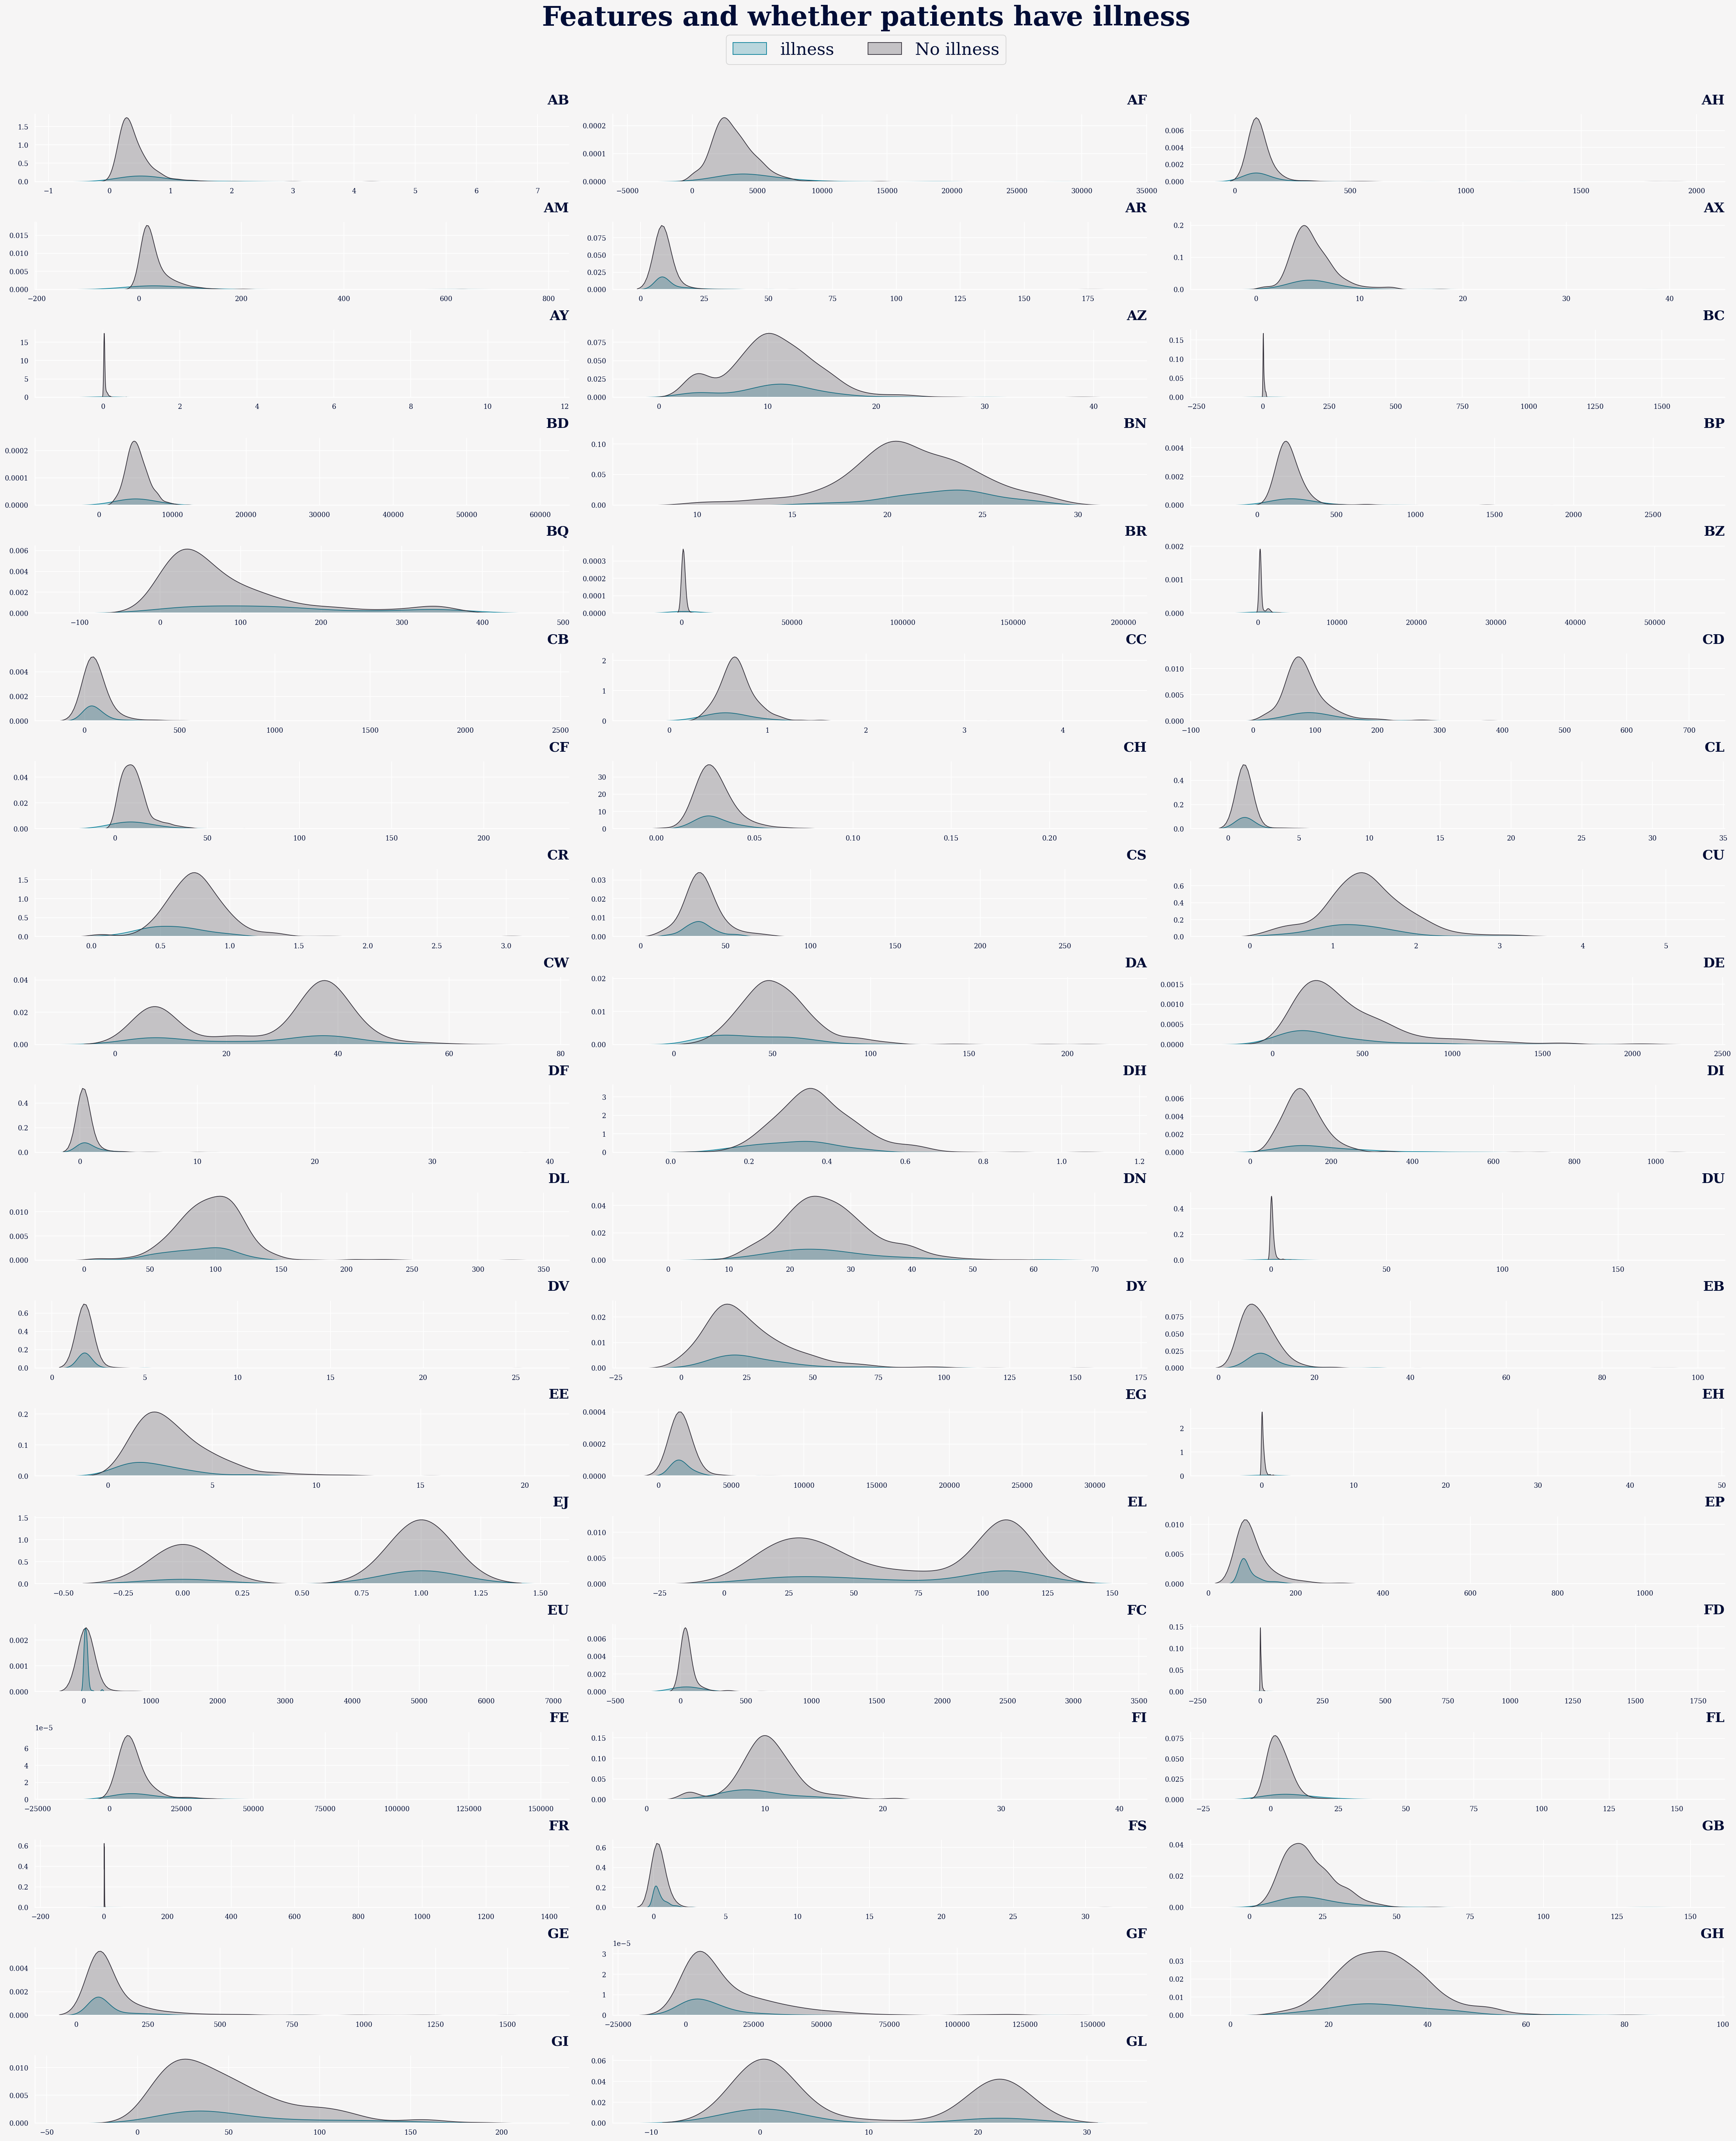

In [40]:
plt.tight_layout()
plt.show()

<ul style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    By looking at the plots above, we can already infer the class imbalance (the distributions of features against Class 1 are either extremely flat or dense).
</ul>

In [16]:
def plot_box(
    df: pd.DataFrame,
    num_cols=4,
    num_rows=14,
    width=1100,
    height=2000,
    title="Box Plots for Each Column",
):
    column_names = df.columns
    num_cols = num_cols
    num_rows = num_rows

    num_subplots = num_cols * num_rows

    fig = make_subplots(rows=num_rows, cols=num_cols)

    # Loop through the column names and create box plots
    for i, column in enumerate(column_names[:num_subplots]):
        row = (i // num_cols) + 1
        col = (i % num_cols) + 1
        box_plot_trace = go.Box(x=df[column], name=column)
        fig.add_trace(box_plot_trace, row=row, col=col)

    # Set layout properties
    fig.update_layout(
        title=f"{title}",
        showlegend=False,
        autosize=False,
        width=width,
        height=height,
    )

    fig.show()



In [17]:
plot_box(train.drop(columns = ['Id']))

<ul style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    There are a bunch of outliers in every features
</ul>

<p style="
    font-size: 30px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #010D36;;
">
    <b>Correlation between features</b> 📔
</p>


In [18]:
corr = merged.corr()
corr.style.background_gradient(cmap = 'coolwarm')

<ul style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    Here we have several highly correlated features like BZ vs BC ( 0.91
 ) or DV vs CL ( 0.95
 ). Such extreme linear correlations give hope for rejecting certain features. Remember that you can zoom in on this matrix and explore specific relations. In the other case, you won't be able to see anything.
</ul>



<p style="
    font-size: 30px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #010D36;;
">
    <b>Find high correlation</b> 📔
</p>

In [19]:
high_corr_points = np.where((np.abs(corr) > 0.7)& (np.abs(corr) != 1))
correlation = []
# Tạo danh sách các tên cột và hàng tương ứng
column_names = corr.columns.tolist()
row_names = corr.index.tolist()

count = 0
high_corr = []
# In các điểm và giá trị tương quan tương ứng
for i, j in zip(high_corr_points[0], high_corr_points[1]):
    if i>j:
        correlation = corr.iloc[i, j]
        high_corr.append([column_names[i], row_names[j],round(correlation,2)])
high_corr = np.asarray(high_corr)
high_corr_df = pd.DataFrame(high_corr, columns=['feature1','feature2','correlation'])
highest_corr_combinations = high_corr_df[["feature1", "feature2"]].to_numpy()

In [20]:
high_corr_df

feature1 feature2 correlation
0        AR       AH        0.75
1        BD       BC        0.75
2        BZ       BC        0.91
3        CL       AR        0.75
4        CS       AR        0.72
5        DV       AH        0.75
6        DV       AR        0.82
7        DV       CL        0.95
8        EB       AH        0.71
9        EB       AR        0.74
10       EH       DU        0.85
11       EP       AR        0.75
12       EP       CS        0.79
13       EP       DV        0.72
14       EP       EB        0.73
15       FD       DU        0.81
16       FD       EH        0.97
17       GL       EJ       -0.98

In [21]:
def get_n_rows_axes(n_features, n_cols=5, n_rows=None):
    n_rows = int(np.ceil(n_features / n_cols))
    current_col = range(1, n_cols + 1)
    current_row = range(1, n_rows + 1)
    return n_rows, list(product(current_row, current_col))

n_cols = 3
n_rows, axes = get_n_rows_axes(len(highest_corr_combinations), n_cols=n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    horizontal_spacing=0.1,
    vertical_spacing=0.06,
)

show_legend = True

for k, ((current_row, current_col), (feature1, feature2)) in enumerate(zip(axes, highest_corr_combinations)):
    if k > 0:
        show_legend = False

    fig.add_scatter(
        x=train.query("Class == 0")[feature1],
        y=train.query("Class == 0")[feature2],
        mode="markers",
        name="Class 0",
        marker=dict(color="#010D36", size=3, symbol="diamond", opacity=0.5),
        legendgroup="Class 0",
        showlegend=show_legend,
        row=current_row,
        col=current_col,
    )
    fig.add_scatter(
        x=train.query("Class == 1")[feature1],
        y=train.query("Class == 1")[feature2],
        mode="markers",
        name="Class 1",
        marker=dict(color="#FF2079", size=2, symbol="circle", opacity=0.5),
        legendgroup="Class 1",
        showlegend=show_legend,
        row=current_row,
        col=current_col,
    )
    fig.update_xaxes(
        type="log",
        title_text=feature1,
        titlefont_size = 9,
        titlefont_family="Arial Black",
        tickfont_size= 9,
        row=current_row,
        col=current_col,
    )
    fig.update_yaxes(
        type="log",
        title_text=feature2,
        titlefont_size=9,
        titlefont_family="Arial Black",
        tickfont_size=9,
        row=current_row,
        col=current_col,
    )

fig.update_annotations(font_size=14)
fig.update_layout(
    font_color=FONT_COLOR,
    title="Highest Pearson Correlations - Pair Plots",
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    width=840,
    height=1140,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        xanchor="right",
        y=1.01,
        x=1,
        itemsizing="constant",
    ),
)
plt.ioff()

In [22]:
fig.show()

<ul style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>In the case of this dataset, it's impossible to show all pair-plots, so I chose only those most correlated.</li>
    <li>The highest correlation is between <code>EH</code> - <code>FD</code> ($0.97$), and this is clearly visible there. Moreover, values associated with Class $0$ are shifted towards higher values. You can explore this by turning off and turning on a given group using legend. A similar situation occurs within <code>DU</code> - <code>EH</code> and <code>DU</code> - <code>FD</code>. Unfortunately, we don't know what these abbreviations mean.</li>
    <li>Moreover, we can see that many different values of a given feature correspond to one specific value from the second one. It may account for a little problem for machine learning algorithms. Such a situation appears in each of the above relationships.</li>
</ul>



<a id="3"></a>
<h1 style="background-color:white;font-family: 'JetBrains Mono';font-size:350%;color: #0d0d0d; text-align: left;border-radius: 15px 50px;">3. Preprocessing data</h1>

<p style="
    font-size: 30px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #010D36;;
">
    <b>Encoding categorical features</b> 📔
</p>


In [23]:
# Categorical data in merged dataset
cols_object = merged.columns[merged.dtypes == 'object']
merged[cols_object].head()

Id Alpha Beta Gamma Delta    Epsilon
0  000ff2bfdfe9     B    C     G     D  3/19/2019
1  007255e47698     A    C     M     B    Unknown
2  013f2bd269f5     A    C     M     B    Unknown
3  043ac50845d5     A    C     M     B    Unknown
4  044fb8a146ec     D    B     F     B  3/25/2020

In [24]:
# Categorical data encoding
le = LabelEncoder()
for col in merged.columns[merged.dtypes == 'object']:
    if col not in ['Id', 'Epsilon']:
        merged[col] = le.fit_transform(merged[col])
        
merged[cols_object].head(3)

Id  Alpha  Beta  Gamma  Delta    Epsilon
0  000ff2bfdfe9      1     2      4      3  3/19/2019
1  007255e47698      0     2      6      1    Unknown
2  013f2bd269f5      0     2      6      1    Unknown

<p style="
    font-size: 30px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #010D36;;
">
    <b>Dealing with missing value</b> 📔
</p>


<ul style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    We used multiple imputation in this case to fill missing data.<br>
    Multiple imputation use the relationship between other features to infer missing points and iterate those step a great deal of times.
</ul>



In [25]:
def FILL_NAN(df):
    # Create the IterativeImputer model to predict missing values
    imp = IterativeImputer(max_iter=50, random_state=0)

    # Fit the model to the test dataset
    imp.fit(df)

    # Transform the model on the entire dataset
    df = pd.DataFrame(np.round(imp.transform(df),6), columns=df.columns)
    return df

def Remove_outlier(train_df):
    for thing in train_df:
        lower_bound = train_df[thing].quantile(0.05)
        upper_bound = train_df[thing].quantile(0.95)
        train_df.loc[(train_df[thing]  < lower_bound) | (train_df[thing] > upper_bound),thing] = np.nan
    return train_df

In [26]:
drop_columns = ['Id','Class']
df_copy = train.drop(['Id','Class'], axis=1).copy(deep = False)
train_filled = FILL_NAN(Remove_outlier(FILL_NAN(df_copy)))
train_filled['Class'] = train['Class']
train_filled['Id'] = train['Id']
train_filled.head(10)

AB           AF          AH         AM         AR        AX  \
0  0.209377  3109.033290   85.200147  22.394407   8.138688  4.779092   
1  0.242489  2571.610189   85.200147  36.968889   8.138688  3.632190   
2  0.470030  2635.106540   85.200147  32.360553   8.138688  6.732840   
3  0.252107  3819.651770  120.201618  77.112203   8.138688  3.685344   
4  0.380297  3733.048440   85.200147  14.103738   8.138688  3.942255   
5  0.209377  2615.814300   85.200147   8.541526   8.138688  4.013127   
6  0.348250  1733.654120   85.200147   8.377385  15.312480  5.508521   
7  0.269199  3084.310567   85.200147  21.174189   8.138688  4.987617   
8  0.346113  3238.436740   85.200147  28.888816   8.138688  4.021986   
9  0.324748  5188.682070   85.200147  12.968688   8.138688  4.593392   

         AY         AZ        BC          BD  ...        FR        FS  \
0  0.025578   9.812214  5.555634  4126.58731  ...  1.738550  0.094822   
1  0.025578  13.517790  1.229900  5496.92824  ...  0.497060  0.568932   
2  0.025578  12.824570  1.229900  5135.78024  ...  0.975560  0.382674   
3  0.025578  11.053708  1.229900  4169.67738  ...  0.497060  0.284466   
4  0.054810   3.396778  3.911806  5728.73412  ...  1.238905  0.121914   
5  0.025578  12.547282  1.229900  5237.54088  ...  0.497060  1.164956   
6  0.025578   6.547778  1.229900  5710.46099  ...  0.861300  0.467337   
7  0.025578   9.408886  1.229900  5040.77914  ...  0.497060  0.277693   
8  0.025578   8.243016  3.626448  6569.37001  ...  1.182620  0.067730   
9  0.025578  10.685041  1.229900  4951.69863  ...  1.571510  0.318331   

          GB          GE            GF         GH          GI         GL  \
0  11.339138   72.611063   2003.810319  22.136229   69.834944   0.120343   
1   9.292698   72.611063  27981.562750  29.135430   32.131996  21.978000   
2  37.077772   88.609437  13676.957810  28.022851   35.192676   0.196941   
3  18.529584   82.416803   2094.262452  39.948656   90.493248   0.155829   
4  16.408728  146.109943   8524.370502  45.381316   36.262628   0.096614   
5  21.915512   72.611063  24177.595550  28.525186   82.527764  21.978000   
6  17.878444  192.453107   3332.467494  34.166222  100.086808   0.065096   
7  18.445866  109.693986  21371.759850  35.208102   31.424696   0.092873   
8  17.245908  147.218610   4589.611956  29.771721   54.675576   0.073416   
9  24.515421   98.929758   5563.130949  21.994831   33.300970  21.978000   

   Class            Id  
0      1  000ff2bfdfe9  
1      0  007255e47698  
2      0  013f2bd269f5  
3      0  043ac50845d5  
4      1  044fb8a146ec  
5      0  04517a3c90bd  
6      0  049232ca8356  
7      0  057287f2da6d  
8      0  0594b00fb30a  
9      0  05f2bc0155cd  

[10 rows x 58 columns]

<ul style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>There are too many outliers here, and the dataset is too small. If we remove the outliers, we would lose a significant amount of data. Therefore, we have decided to replace those data points with NaN and then use multiple imputation to fill in the missing values. This way, we can preserve the integrity of the dataset while also eliminating $10$% of outliers that could cause confusion.</li>
    <li>Here, we are only removing $5$% of outliers on each side to eliminate outliers that strongly affect the data, instead of using the $IQR$ range, as this may result in the loss of important information.</li>
</ul>


<p style="
    font-size: 30px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #010D36;;
">
    <b>Validate missing value</b> 📔
</p>

In [27]:
nulls = merged.isnull()
print("Features have missing and the number of missing value:\n")
for feature in train_filled.columns:
    if train_filled[feature].isnull().any() == True: 
        print(feature,train_filled[feature].isnull().sum())

Features have missing and the number of missing value:



<ul style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    There are no more missing data
</ul>



In [28]:
##Boxplot after removing outliers and filling with imputation
plot_box(train_filled)

<a id="4"></a>
<h1 style="background-color:white;font-family: 'JetBrains Mono';font-size:350%; text-align: left;border-radius: 15px 50px;">4. Building Models</h1>

In [29]:
train_file = 'train.csv'
greeks_file = 'greeks.csv'
test_file = 'test.csv'

train_df = train_filled
greeks_df = pd.read_csv(greeks_file)
test_df = pd.read_csv(test_file)

In [30]:
first_category = train_df.EJ.unique()[0]
train_df.EJ = train_df.EJ.eq(first_category).astype('int')
test_df.EJ = test_df.EJ.eq(first_category).astype('int')

In [31]:
times = greeks_df.Epsilon.copy()
times[greeks_df.Epsilon != 'Unknown'] = greeks_df.Epsilon[greeks_df.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
times[greeks_df.Epsilon == 'Unknown'] = np.nan

<p style="
    font-size: 30px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #010D36;;
">
    <b>Define model</b> 📔
</p>

In [32]:
class WeightedEnsemble(BaseEstimator):
    def __init__(self):
        self.classifiers = [xgboost.XGBClassifier(), TabPFNClassifier(N_ensemble_configurations=64, device='cuda:0')]
#         self.imputer = SimpleImputer(missing_values=np.nan, strategy='median')
        self.imputer = IterativeImputer(max_iter=10, random_state=0)
    
    def fit(self, X, y):
        unique_classes, y = np.unique(y, return_inverse=True)
        self.classes_ = unique_classes
        X = self.imputer.fit_transform(X)
        for classifier in self.classifiers:
            classifier.fit(X, y)
    
    def predict_proba(self, X):
        X = self.imputer.transform(X)
        probabilities = np.stack([classifier.predict_proba(X) for classifier in self.classifiers])
        averaged_probabilities = np.mean(probabilities, axis=0)
        class_0_est_instances = averaged_probabilities[:, 0].sum()
        others_est_instances = averaged_probabilities[:, 1:].sum()
        # Weighted probabilities based on class imbalance
        new_probabilities = averaged_probabilities * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(averaged_probabilities.shape[1])]])
        return new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1)


\tag{with $p_i = probabilities from XGBoost; p_j = probabilities from TabPFN;  $}
    P_{pred} = \begin{vmatrix}
        XG&TabPFN&...&orthers\\
        p_{i1}&p_{j1}&...&p_{o1}\\
        p_{i2}&p_{j2}&...&p_{o2}\\
        p_{i3}&p_{j3}&...&p_{o3}\\
        \vdots & \vdots & \vdots & \vdots \\
        p_{in}&p_{jn}&...&p_{on}\\
    \end{vmatrix} 

    

\begin{equation}
    \tag{with $p_1 = mean(p_{i}); p_2 = mean(p_{j})$}
    P_{AVG} = \begin{vmatrix}
        AVG_{XG}&AVG_{TabPFN}&...&orthers\\
        p_1&p_2&...&p_o\\
    \end{vmatrix} 
\end{equation}

\begin{align*}
    class_{0_{est}} = p_1\\
    orthers_{est} =  \sum_{2}^{o} p_i
\end{align*}

\begin{equation*}
    P_{AVG_{new}} = \begin{vmatrix}
        AVG_{XG}&AVG_{TabPFN}&...&orthers\\
        \frac{p_1}{class_{0_{est}}}&\frac{p_2}{orthers_{est}}&...&\frac{p_o}{orthers_{est}}\\
    \end{vmatrix} 
\end{equation*}

\begin{equation*}
    P_{AVG_{new}} = \begin{vmatrix}
        AVG_{XG}&AVG_{TabPFN}&...&orthers\\
        p_{n1}&p_{n2}&...&p_{no}\\
    \end{vmatrix} 
\end{equation*}

\begin{equation*}
    RES = \begin{vmatrix}
        AVG_{XG}&AVG_{TabPFN}&...&orthers\\
        \frac{p_{n1}}{\sum_{1}^{o} p_n}&\frac{p_{n2}}{\sum_{1}^{o} p_n}&...&\frac{p_{no}}{\sum_{1}^{o} p_n}\\
    \end{vmatrix} 
\end{equation*}

$$
\begin{equation}
    P_{pred} = \begin{vmatrix}
        XG&TabPFN&...&orthers\\
        p_{i1}&p_{j1}&...&p_{o1}\\
        p_{i2}&p_{j2}&...&p_{o2}\\
        p_{i3}&p_{j3}&...&p_{o3}\\
        \vdots & \vdots & \vdots & \vdots \\
        p_{in}&p_{jn}&...&p_{on}\\
    \end{vmatrix}\\
    \text{(with } p_i = \text{probabilities from XGBoost; } p_j = \text{probabilities from TabPFN )}
\end{equation}
$$ 
\
$$
\begin{equation}
    P_{AVG} = \begin{vmatrix}
        AVG_{XG}&AVG_{TabPFN}&...&orthers\\
        p_1&p_2&...&p_o\\
    \end{vmatrix} 
\end{equation}\\
\text{(with $p_1$ = mean($p_i$); $p_2$ = mean($p_j$))}\\
$$


\begin{align*}
    class_{0_{est}} = p_1\\
    orthers_{est} =  \sum_{2}^{o} p_i
\end{align*}

\begin{equation*}
    P_{AVG_{new}} = \begin{vmatrix}
        AVG_{XG}&AVG_{TabPFN}&...&orthers\\
        \frac{p_1}{class_{0_{est}}}&\frac{p_2}{orthers_{est}}&...&\frac{p_o}{orthers_{est}}\\
    \end{vmatrix} 
\end{equation*}

\begin{equation*}
    P_{AVG_{new}} = \begin{vmatrix}
        AVG_{XG}&AVG_{TabPFN}&...&orthers\\
        p_{n1}&p_{n2}&...&p_{no}\\
    \end{vmatrix} 
\end{equation*}

\begin{equation*}
    RES = \begin{vmatrix}
        AVG_{XG}&AVG_{TabPFN}&...&orthers\\
        \frac{p_{n1}}{\sum_{1}^{o} p_n}&\frac{p_{n2}}{\sum_{1}^{o} p_n}&...&\frac{p_{no}}{\sum_{1}^{o} p_n}\\
    \end{vmatrix} 
\end{equation*}


<p style="
    font-size: 30px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #010D36;;
">
    <b>Preparing data</b> 📔
</p>

In [33]:
target_column = 'Class'
predictor_columns = [n for n in train_df.columns if n != target_column and n != 'Id']

X = train_df[predictor_columns].values
y = train_df[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<p style="
    font-size: 30px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #010D36;;
">
    <b>Applying model</b> 📔
</p>

In [34]:
model = WeightedEnsemble()
model.fit(X_train, y_train)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [35]:
#TabPFNClassifier(N_ensemble_configurations=64,device='cuda:0')
probabilities = model.predict_proba(X_test)
#assert (model.classes_[0] == 'A')
probabilities = np.concatenate((probabilities[:,:1], np.sum(probabilities[:,1:], 1, keepdims=True)), axis=1)

In [36]:
p0 = probabilities[:,:1]
p0[p0 > 0.86] = 1
p0[p0 < 0.14] = 0

<p style="
    font-size: 30px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #010D36;;
">
    <b>Evaluation</b> 📔
</p>
<br>
<ul style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    We use the following loss function to evaluate our model
</ul>



\begin{align}
\text{Log Loss} = \frac{-\frac{1}{N_{0}} \sum_{i=1}^{N_{0}} y_{0 i} \log  p_{0 i} - \frac {1}{N_{1}} \sum_{i=1}^{N_{1}} y_{1 i} \log  p_{1 i} } { 2 }
\end{align}

In [37]:
def competition_log_loss(y_true,y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    #y_pred = y_pred.T[1]
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # Calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # Calculate the average log loss for each class
    sum_0 = -np.sum((1 - y_true) * np.log(p_0))
    sum_1 = -np.sum(y_true * np.log(p_1))
    to_output = ((1 / N_0) * sum_0 + (1 / N_1) * sum_1) / 2

    return to_output

In [38]:
competition_log_loss(y_test,1-p0.T)

0.1761056796619126

<ul style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #0d0d0d;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>The goal is to minimize the log loss, with lower values indicating better model performance and higher values indicating poorer performance.</li>
    <li>Here, our achieved log loss is $0.18$, which demonstrates that the model performs quite accurately.</li>
</ul>


<h1 style="background-color:white;font-family: 'JetBrains Mono';font-size:350%; text-align: left;border-radius: 15px 50px;">5. References</h1><a id="5"></a>

<a>https://www.kaggle.com/code/oscarm524/icr-eda-modeling-submission/notebook</a>

<a>https://www.kaggle.com/code/ayushs9020/understanding-the-competition-icr-eda</a>

<a>https://www.kaggle.com/code/divyanshikapoor05/icr-eda-for-beginners#About-the-Competition</a>

<a>https://arxiv.org/abs/2207.01848</a>

<a>https://www.kaggle.com/code/sugataghosh/icr-the-devil-is-in-the-greeks</a>

<a>https://www.kaggle.com/code/vadimkamaev/icr-identify-age</a>

<a>https://www.kaggle.com/code/mateuszk013/icr-eda-balanced-learning-with-lgbm-xgb?scriptVersionId=133083942</a>